In [7]:
import torch
import torchvision

model = torchvision.models.segmentation.__dict__["deeplabv3_resnet50"](aux_loss=True, num_classes=2)

checkpoint = torch.load("model_19.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"], strict=False)


<All keys matched successfully>

In [32]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
url, filename = ("https://media.npr.org/assets/img/2022/09/13/gettyimages-487650860_custom-174c3c7796164a52cbeef513377ad62540eda4a6-s800-c85.webp", "girls.png")
url, filename = ("https://www.nme.com/wp-content/uploads/2021/03/031621-Brave-Girls-Brave-Entertainment.jpg", "brave-girls.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [33]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image.show()
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
model.eval()
with torch.no_grad():
    output = model(input_batch)['out'][0]

output_predictions = output.argmax(0)

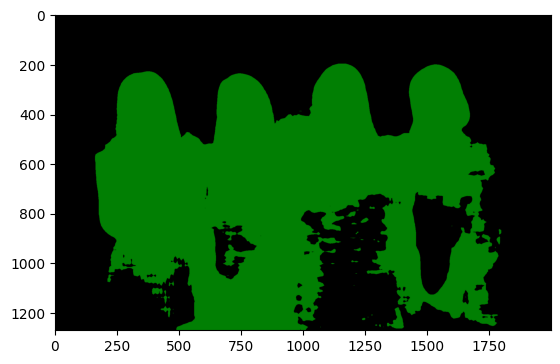

In [34]:

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 2 - 1])
colors = torch.as_tensor([i for i in range(2)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

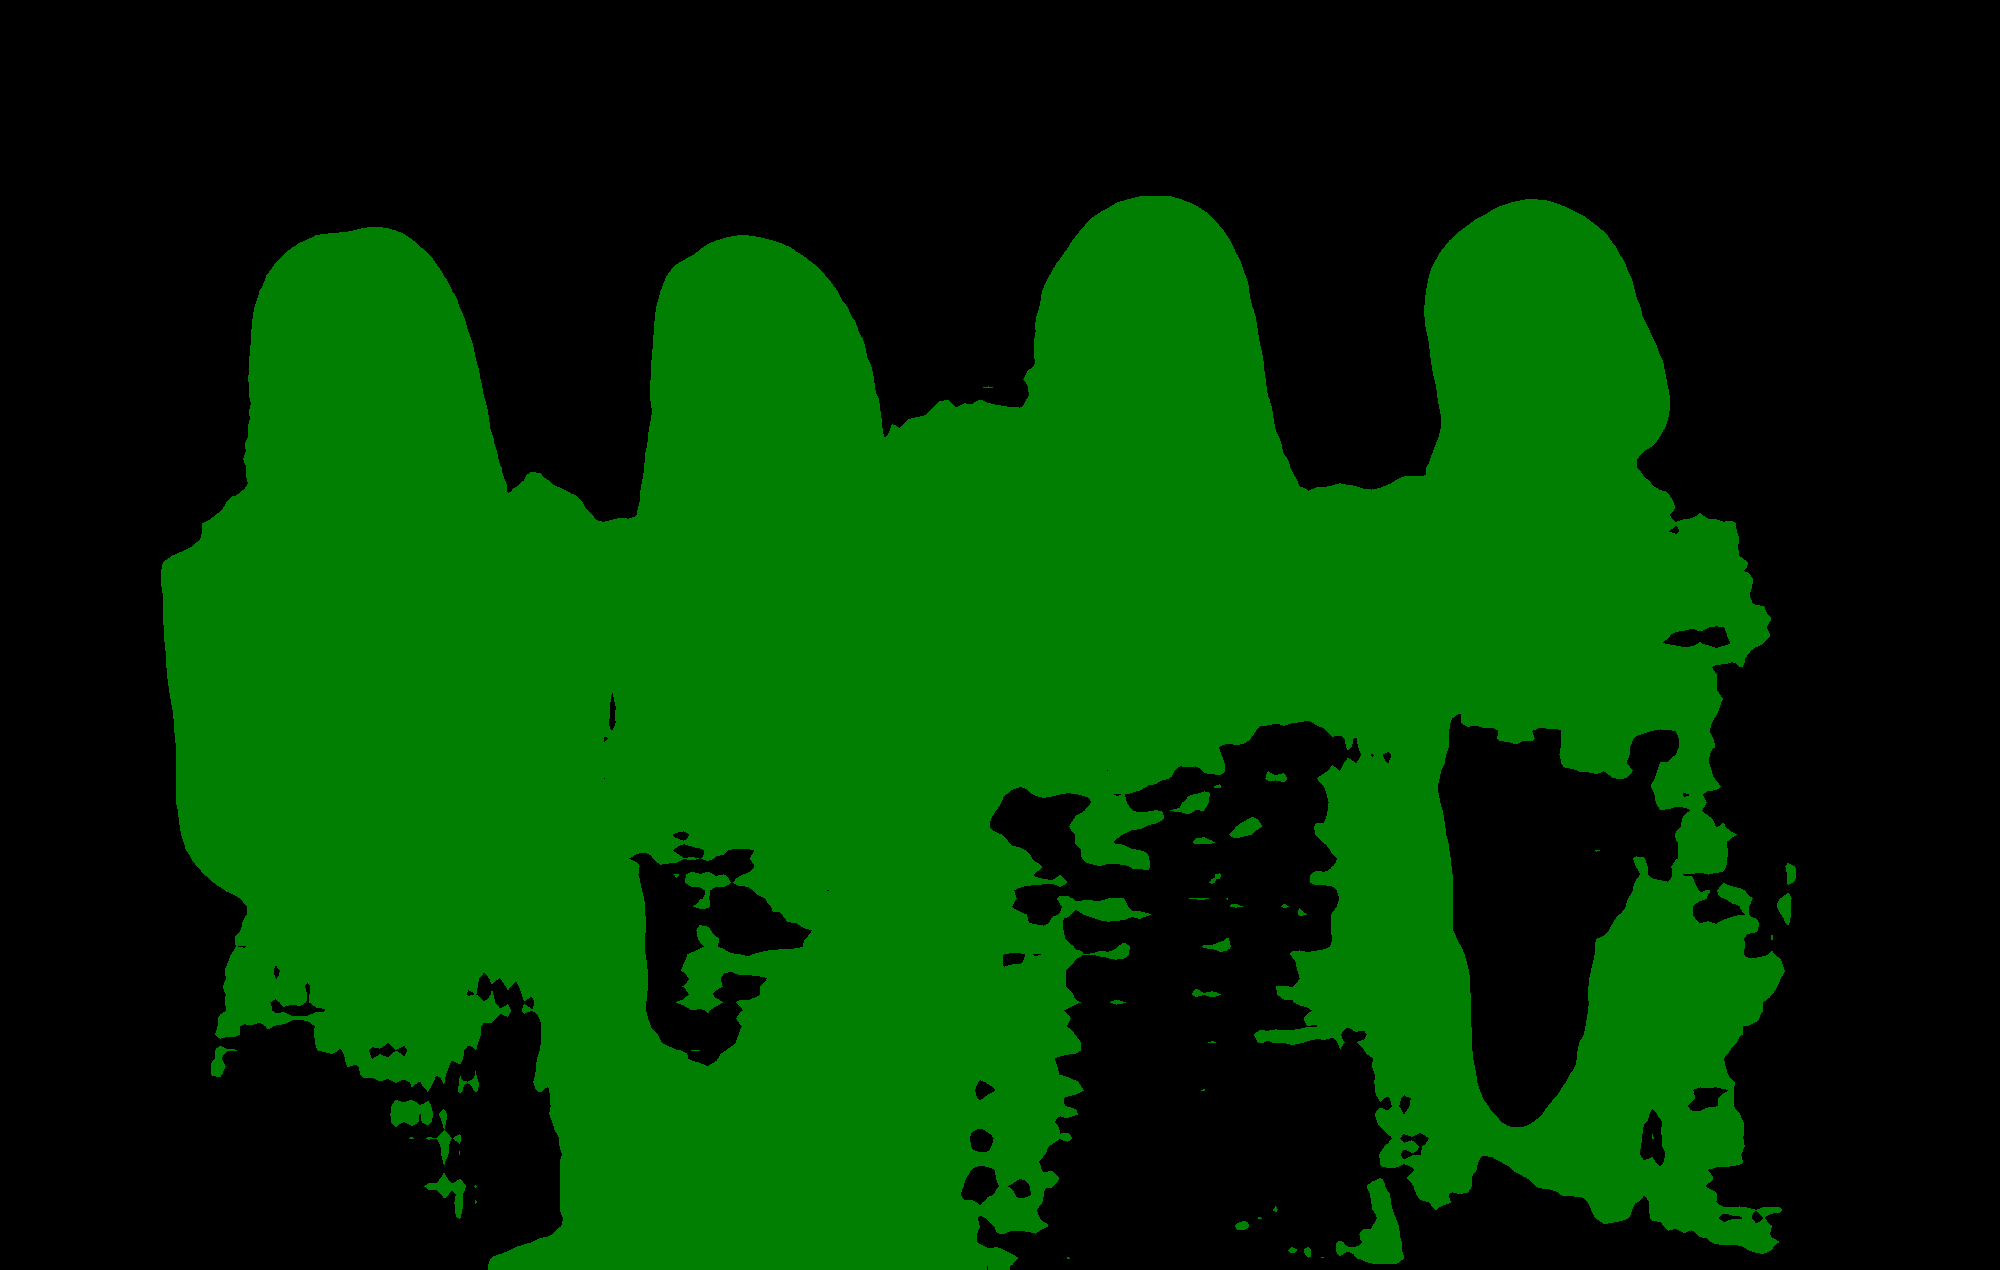

In [35]:
r

In [48]:
import numpy as np
import cv2
in_img = np.array(input_image)

out_img = np.array(r)

ModuleNotFoundError: No module named 'cv2'

In [42]:
in_img.shape

(1270, 2000, 3)

In [44]:
out_img.shape

(1270, 2000)

In [45]:
dst = cv2.bitwise_and(in_img, out_img)

cv2.imwrite('bitwise_and.jpg', dst)

NameError: name 'cv2' is not defined